#### Importação das bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,gc
import seaborn as sns
import matplotlib.dates as mdates

## Preparação dos dados

### Entendendo as relações entre as tabelas:

<img src="https://i.imgur.com/HRhd2Y0.png" width="600" height="400">

Através do esquema do BD disponibilizado pelo Kaggle, pode-se entender as relações entre as tabelas.

De acordo com a descrição do dataset no <a href="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv">kaggle</a>, a principal tabela `olist_orders_dataset` onde é possível obter as demais informações sobre o pedido.

#### Carregamento dos datasets

In [4]:
olist_orders_dataset = pd.read_csv(os.path.join('olist', 'olist_orders_dataset.csv'))
olist_order_items_dataset = pd.read_csv(os.path.join('olist', 'olist_order_items_dataset.csv'))
olist_customers_dataset = pd.read_csv(os.path.join('olist', 'olist_customers_dataset.csv'))
olist_products_dataset = pd.read_csv(os.path.join('olist', 'olist_products_dataset.csv'))
olist_sellers_dataset = pd.read_csv(os.path.join('olist', 'olist_sellers_dataset.csv'))
olist_order_payments_dataset = pd.read_csv(os.path.join('olist', 'olist_order_payments_dataset.csv'))
olist_order_reviews_dataset = pd.read_csv(os.path.join('olist', 'olist_order_reviews_dataset.csv'))
product_category_name_translation = pd.read_csv(os.path.join('olist', 'product_category_name_translation.csv'))
olist_geolocation_dataset = pd.read_csv(os.path.join('olist', 'olist_geolocation_dataset.csv'))

#### Implementação de uma função para verificação de nulidade e duplicidade

In [5]:
def verify_duplicate_null(df:pd.DataFrame,type=0)->tuple[bool, bool]:
    is_null = True if df.isnull().sum().sum() > 0 else False
    print(f'Colunas com valores nulos:\n{df.isnull().sum()}')
    is_duplicated =  True if df.duplicated().sum() > 0 else False
    print(f'Número de linhas duplicados: {df.duplicated().sum()}')
    return is_null, is_duplicated


### Vamos entender a tabela `olist_orders_dataset`

In [6]:
print(olist_orders_dataset.info())
verify_duplicate_null(olist_orders_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
Colunas com valores nulos:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
or

(True, False)

In [7]:
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
def transform_str_datetime(df:pd.DataFrame,cols:list)->pd.DataFrame:
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

olist_orders_dataset = transform_str_datetime(olist_orders_dataset,date_columns)

# Verify the conversion
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


As linhas que contêm colunas nulas envolvem a dimensão temporal, o que é essencial para análise de dados. Então irei remover as linhas que possuam colunas nulas.

In [8]:
olist_orders_dataset = olist_orders_dataset.dropna()
olist_orders_dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


Verificando se a `orders_id` é única.

In [9]:
olist_orders_dataset['order_id'].duplicated().sum()

0

### Vamos agora verificar o `olist_order_items_dataset`

In [10]:
print(olist_order_items_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None


In [11]:
verify_duplicate_null(olist_order_items_dataset)

Colunas com valores nulos:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Número de linhas duplicados: 0


(False, False)

In [12]:
olist_order_items_dataset['shipping_limit_date'] = pd.to_datetime(olist_order_items_dataset['shipping_limit_date'])

### Verificação da tabela `olist_order_payments_dataset`

In [13]:
olist_order_payments_dataset.info()
verify_duplicate_null(olist_order_payments_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Colunas com valores nulos:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
Número de linhas duplicados: 0


(False, False)

### Verificação da tabela `olist_order_reviews_dataset`


In [14]:
olist_order_reviews_dataset.info()
verify_duplicate_null(olist_order_reviews_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
Colunas com valores nulos:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
Número de linhas duplicados: 0


(True, False)

Verificando as linhas com valores nulos.

In [15]:
#Os valores nulos serão transformados em valores vazios
olist_order_reviews_dataset = olist_order_reviews_dataset.fillna('')

In [16]:
olist_order_reviews_dataset['order_id'].duplicated().sum()

551

transformando as colunas que contêm datas em timestamp

In [17]:
date_columns_reviews = [
    'review_creation_date',
    'review_answer_timestamp'
]

olist_order_reviews_dataset = transform_str_datetime(olist_order_reviews_dataset,date_columns_reviews)
olist_order_reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     99224 non-null  object        
 4   review_comment_message   99224 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


### Verificação da tabela `olist_products_dataset`

In [18]:
olist_products_dataset.info()
verify_duplicate_null(olist_products_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
Colunas com valores nulos:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g

(True, False)

In [19]:
# Não faz sentido um produto não possuir categoria, então irei remover as linhas nulas
olist_products_dataset = olist_products_dataset.dropna()

### Verificação da tabela `olist_sellers_dataset`

In [20]:
olist_sellers_dataset.info()
verify_duplicate_null(olist_sellers_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
Colunas com valores nulos:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
Número de linhas duplicados: 0


(False, False)

### Verificação da tabela `olist_order_customer_dataset`

In [21]:
olist_customers_dataset.info()
verify_duplicate_null(olist_customers_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
Colunas com valores nulos:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Número de linhas duplicados: 0


(False, False)

### Verificação da tabela `olist_geolocation_dataset`

In [22]:
olist_geolocation_dataset.info()
verify_duplicate_null(olist_geolocation_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
Colunas com valores nulos:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
Número de linhas duplicados: 261831


(False, True)

Removendo as linhas duplicadas

In [23]:
olist_geolocation_dataset = olist_geolocation_dataset.drop_duplicates()
verify_duplicate_null(olist_geolocation_dataset)

Colunas com valores nulos:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
Número de linhas duplicados: 0


(False, False)

### Verificando integridade referencial

In [24]:
def check_referential_integrity(primary_df: pd.DataFrame, secondary_df: pd.DataFrame, key_columns = []) ->  set:
    # Find IDs that exist in secondary but not in primary
    if len(key_columns)==1:
        key_column = key_columns[0]
        orphaned_ids = set(secondary_df[key_column]) - set(primary_df[key_column])
    else:
        orphaned_ids = set(secondary_df[key_columns[1]]) - set(primary_df[key_columns[0]])
    print(f"Checking referential integrity for {key_columns[0]}")
    print(f"Total records in primary DataFrame: {len(primary_df)}")
    print(f"Total records in secondary DataFrame: {len(secondary_df)}")
    print(f"IDs that exist in secondary but not in primary: {len(orphaned_ids)}")
    if len(orphaned_ids) > 0:
        print("Example of orphaned IDs:",list(orphaned_ids)[:3])
        return orphaned_ids
    return set()

In [25]:
check_referential_integrity(olist_customers_dataset,olist_orders_dataset,['customer_id'])

Checking referential integrity for customer_id
Total records in primary DataFrame: 99441
Total records in secondary DataFrame: 96461
IDs that exist in secondary but not in primary: 0


set()

Considerando que não há inconsistência entre `olist_customers_dataset` e `olist_orders_dataset`, o próximo passo é verificar com as outras tabelas.

In [26]:
ids_reviews_orders = check_referential_integrity(olist_orders_dataset, olist_order_reviews_dataset,['order_id'])

Checking referential integrity for order_id
Total records in primary DataFrame: 96461
Total records in secondary DataFrame: 99224
IDs that exist in secondary but not in primary: 2858
Example of orphaned IDs: ['a69ba794cc7deb415c3e15a0a3877e69', 'c526fe83c01c48066394ff5d81f9ab9a', 'e724300bcd73fb1c467b1c20c33a1fdd']


Excluindo as reviews orfãs do `olist_order_reviews_dataset`

In [27]:
olist_order_reviews_dataset = olist_order_reviews_dataset[~olist_order_reviews_dataset['order_id'].isin(ids_reviews_orders)]
check_referential_integrity(olist_orders_dataset, olist_order_reviews_dataset,['order_id'])

Checking referential integrity for order_id
Total records in primary DataFrame: 96461
Total records in secondary DataFrame: 96344
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre `olist_order_payments_dataset` e `olist_orders_dataset`

In [28]:
ids_payments_orders = check_referential_integrity(olist_orders_dataset, olist_order_payments_dataset,['order_id'])

Checking referential integrity for order_id
Total records in primary DataFrame: 96461
Total records in secondary DataFrame: 103886
IDs that exist in secondary but not in primary: 2980
Example of orphaned IDs: ['a69ba794cc7deb415c3e15a0a3877e69', 'c526fe83c01c48066394ff5d81f9ab9a', 'e724300bcd73fb1c467b1c20c33a1fdd']


In [29]:
olist_order_payments_dataset = olist_order_payments_dataset[~olist_order_payments_dataset['order_id'].isin(ids_payments_orders)]
check_referential_integrity(olist_orders_dataset, olist_order_payments_dataset,['order_id'])

Checking referential integrity for order_id
Total records in primary DataFrame: 96461
Total records in secondary DataFrame: 100739
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre `olist_order_items_dataset` e `olist_orders_dataset`

In [30]:
check_referential_integrity(olist_order_items_dataset,olist_orders_dataset,['order_id'])

Checking referential integrity for order_id
Total records in primary DataFrame: 112650
Total records in secondary DataFrame: 96461
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre `olist_order_items_dataset` e `olist_products_dataset`

In [31]:
ids_items_product =  check_referential_integrity(olist_products_dataset,olist_order_items_dataset,['product_id'])

Checking referential integrity for product_id
Total records in primary DataFrame: 32340
Total records in secondary DataFrame: 112650
IDs that exist in secondary but not in primary: 611
Example of orphaned IDs: ['c2ddba1b0149af8ce1b6b0d220f0411a', 'bbdef93b1bffe87d66bc97697e58c1ad', '516f4c728fa63b7394b4a4d99a010ff6']


In [32]:
olist_order_items_dataset = olist_order_items_dataset[~olist_order_items_dataset['product_id'].isin(ids_items_product)]
check_referential_integrity(olist_products_dataset,olist_order_items_dataset,['product_id'])

Checking referential integrity for product_id
Total records in primary DataFrame: 32340
Total records in secondary DataFrame: 111046
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre `olist_order_items_dataset` e `olist_sellers_dataset`

In [33]:
check_referential_integrity(olist_sellers_dataset,olist_order_items_dataset,['seller_id'])

Checking referential integrity for seller_id
Total records in primary DataFrame: 3095
Total records in secondary DataFrame: 111046
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre `olist_sellers_dataset` e `olist_geolocation_dataset`

In [34]:
print(olist_geolocation_dataset.columns)
print(olist_sellers_dataset.columns)

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')


In [35]:
ids_zip_code = check_referential_integrity(olist_geolocation_dataset,olist_sellers_dataset,['geolocation_zip_code_prefix','seller_zip_code_prefix'])

Checking referential integrity for geolocation_zip_code_prefix
Total records in primary DataFrame: 738332
Total records in secondary DataFrame: 3095
IDs that exist in secondary but not in primary: 7
Example of orphaned IDs: [72580, 37708, 2285]


In [36]:
olist_sellers_dataset = olist_sellers_dataset[~olist_sellers_dataset['seller_zip_code_prefix'].isin(ids_zip_code)]
check_referential_integrity(olist_geolocation_dataset,olist_sellers_dataset,['geolocation_zip_code_prefix','seller_zip_code_prefix'])

Checking referential integrity for geolocation_zip_code_prefix
Total records in primary DataFrame: 738332
Total records in secondary DataFrame: 3088
IDs that exist in secondary but not in primary: 0


set()

Verificando inconsistências entre  `olist_geolocation_dataset` e `olist_customers_dataset`

In [37]:
olist_customers_dataset.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [38]:
ids_zip_code_customer = check_referential_integrity(olist_geolocation_dataset,olist_customers_dataset,['geolocation_zip_code_prefix','customer_zip_code_prefix'])

Checking referential integrity for geolocation_zip_code_prefix
Total records in primary DataFrame: 738332
Total records in secondary DataFrame: 99441
IDs that exist in secondary but not in primary: 157
Example of orphaned IDs: [28160, 56327, 75784]


In [39]:
olist_customers_dataset = olist_customers_dataset[~olist_customers_dataset['customer_zip_code_prefix'].isin(ids_zip_code_customer)]
check_referential_integrity(olist_geolocation_dataset,olist_customers_dataset,['geolocation_zip_code_prefix','customer_zip_code_prefix'])

Checking referential integrity for geolocation_zip_code_prefix
Total records in primary DataFrame: 738332
Total records in secondary DataFrame: 99163
IDs that exist in secondary but not in primary: 0


set()

### Relacionamentos entre tabelas

O relacionamento entre `olist_orders_dataset` e `olist_order_reviews_dataset` deve ser de 1:1 pois um pedido deve conter apenas uma avaliação.

In [40]:
df_orders = pd.merge(olist_orders_dataset,olist_order_reviews_dataset,
                    on='order_id',how='inner')
print(f'orders + review: {len(df_orders)}')
print(f'orders:{len(olist_orders_dataset)}')

orders + review: 96344
orders:96461


In [41]:
olist_order_reviews_dataset['order_id'].duplicated().sum()

529

In [42]:
df_orders['order_id'].duplicated().sum()

529

In [43]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

O relacionamento entre `olist_orders_dataset` e `olist_order_payments_dataset` deve ser de 1:m pois em 1 pedido pode conter m métodos de pagamentos.

In [44]:
olist_order_payments_dataset.duplicated(subset='order_id').sum()

4279

In [45]:
df_orders = pd.merge(df_orders,olist_order_payments_dataset,on='order_id',
                    how='left',validate='1:m')
df_orders.info()

MergeError: Merge keys are not unique in left dataset; not a one-to-many merge

Analisando o relacionamento entre as tabelas `olist_customers_dataset` e `olist_geolocation_dataset`

In [78]:
df_customer_location =  pd.merge(olist_customers_dataset,olist_geolocation_dataset,
                                left_on='customer_zip_code_prefix',
                                right_on='geolocation_zip_code_prefix',
                                how='inner').drop(columns=['geolocation_zip_code_prefix'])
df_customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10327728 entries, 0 to 10327727
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   customer_id               object 
 1   customer_unique_id        object 
 2   customer_zip_code_prefix  int64  
 3   customer_city             object 
 4   customer_state            object 
 5   geolocation_lat           float64
 6   geolocation_lng           float64
 7   geolocation_city          object 
 8   geolocation_state         object 
dtypes: float64(2), int64(1), object(6)
memory usage: 709.1+ MB


Não faz sentido criar este relacionamento por conta do uso da memória, `memory usage: memory usage: 709.1+ MB`

In [79]:
del df_customer_location
gc.collect()

474

Relacionando `olist_customers_dataset` e `df_orders`

In [77]:
olist_customers_dataset.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [78]:
df_orders_customer = pd.merge(df_orders,olist_customers_dataset,
                    on=['customer_id'],how='right',validate='m:m')
df_orders_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99689 entries, 0 to 99688
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96078 non-null  object        
 1   customer_id                    99689 non-null  object        
 2   order_status                   96078 non-null  object        
 3   order_purchase_timestamp       96078 non-null  datetime64[ns]
 4   order_approved_at              96078 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96078 non-null  datetime64[ns]
 6   order_delivered_customer_date  96078 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96078 non-null  datetime64[ns]
 8   review_id                      96078 non-null  object        
 9   review_score                   96078 non-null  float64       
 10  review_comment_title           96078 non-null  object        
 11  review_comment_

In [110]:
df_orders['customer_id'].duplicated().sum()

4818

In [111]:
df_orders_customer['customer_id'].duplicated().sum()

4807

## Análise Exploratória de Dados

### Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

#### Primeiro vamos obter o volume de pedido por mês

In [49]:
# Criar uma série temporal mensal de pedidos
monthly_orders = olist_orders_dataset.groupby([
    olist_orders_dataset['order_purchase_timestamp'].dt.year,
    olist_orders_dataset['order_purchase_timestamp'].dt.month,
]).size()

In [50]:
# Criar um índice de data para a série temporal
monthly_orders.index = pd.to_datetime(
    [f"{year}-{month:02d}-01" for year, month in monthly_orders.index]
)

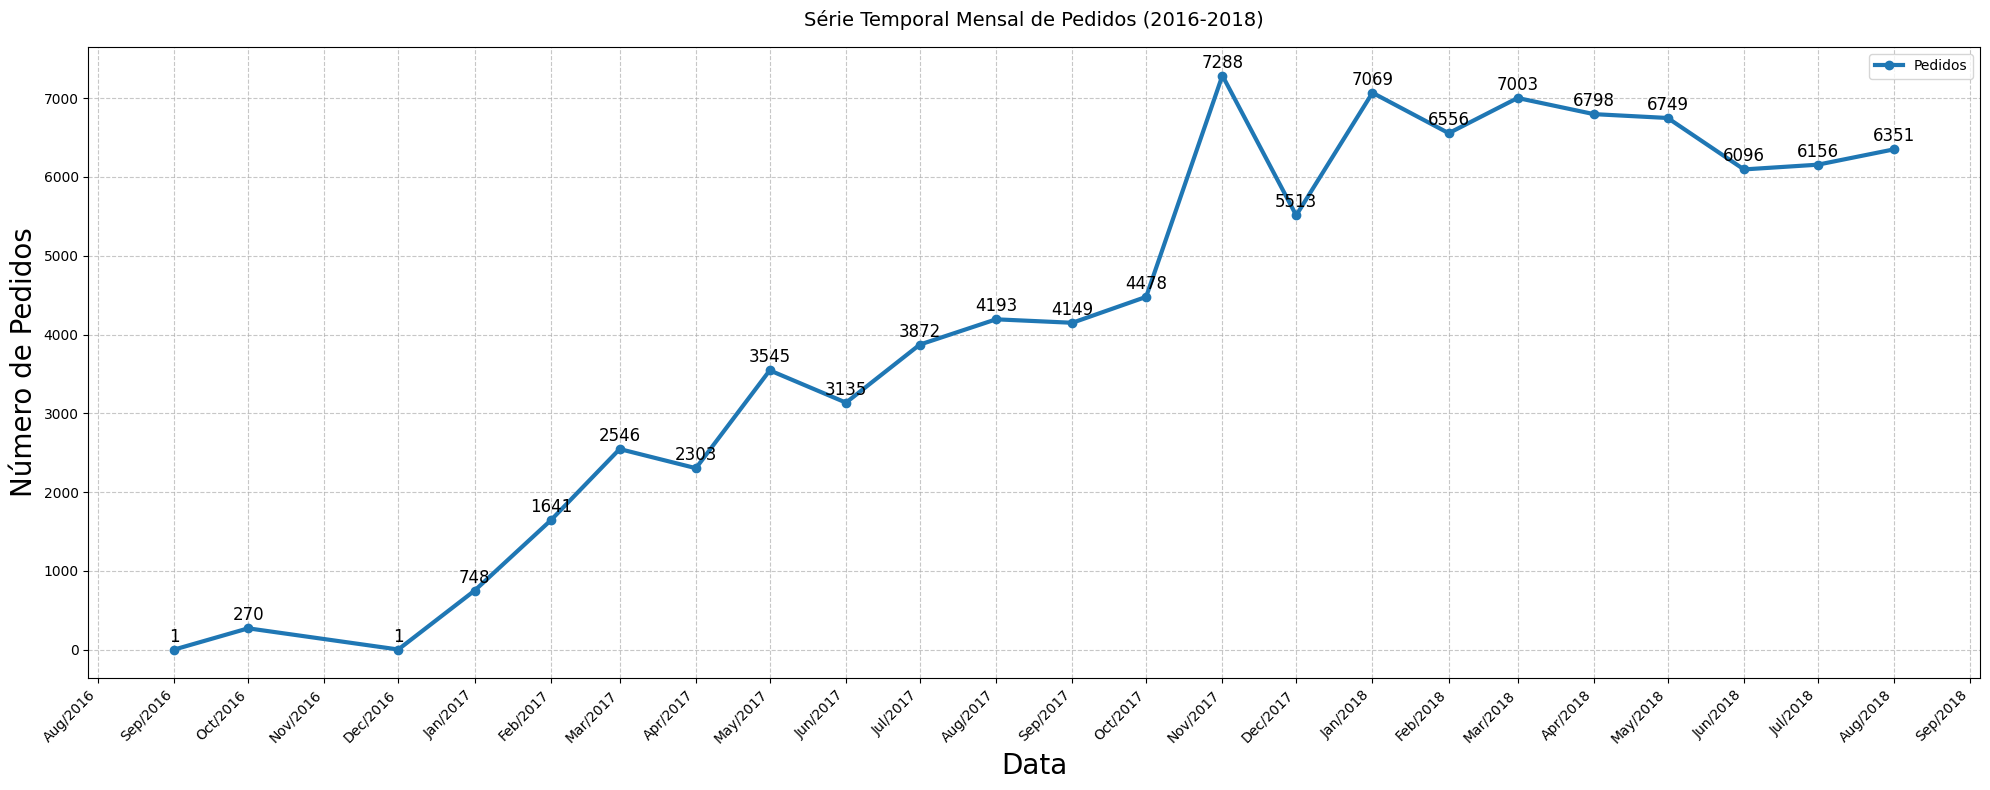

In [51]:
# Criar a figura com tamanho maior para acomodar todos os meses
plt.figure(figsize=(20, 8))

# Plotar a série temporal
plt.plot(monthly_orders.index, monthly_orders.values, 
        marker='o', linewidth=3, markersize=6)
for i,j in zip(monthly_orders.index,monthly_orders.values):
    plt.text(i,j+50,j,ha='center',va='bottom',fontsize=12)
# Personalizar o gráfico
plt.title('Série Temporal Mensal de Pedidos (2016-2018)', fontsize=14, pad=15)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Número de Pedidos', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Formatar o eixo x para mostrar mês/ano
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
# Mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Rotacionar as labels do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Adicionar legenda
plt.legend(['Pedidos'])

# Ajustar o layout para evitar corte das labels
plt.tight_layout()

# Mostrar o gráfico
plt.show()


Será considerado para análise apenas o período de janeiro de 2017 até agosto de 2018.

In [83]:
years = [2017, 2018]
monthly_orders_valid = pd.concat([
    monthly_orders.loc[f'{year}-01-01':f'{year}-08-01'] for year in years
])

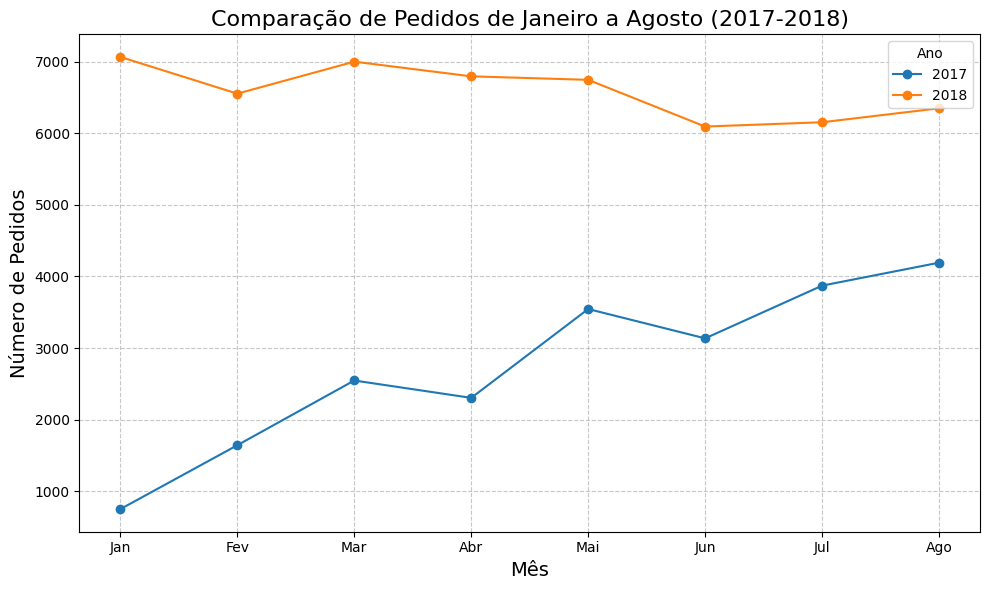

In [71]:
# Garantir que o índice é datetime
monthly_orders_valid.index = pd.to_datetime(monthly_orders_valid.index)

# Agrupar por mês e ano usando o próprio índice
pivot = monthly_orders_valid.groupby([monthly_orders_valid.index.month, monthly_orders_valid.index.year]).sum().unstack()

# Plotar
pivot.plot(marker='o', figsize=(10, 6))

# Customização
plt.title('Comparação de Pedidos de Janeiro a Agosto (2017-2018)', fontsize=16)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Número de Pedidos', fontsize=14)
plt.xticks(ticks=range(1, 9), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Ano')
plt.tight_layout()
plt.show()

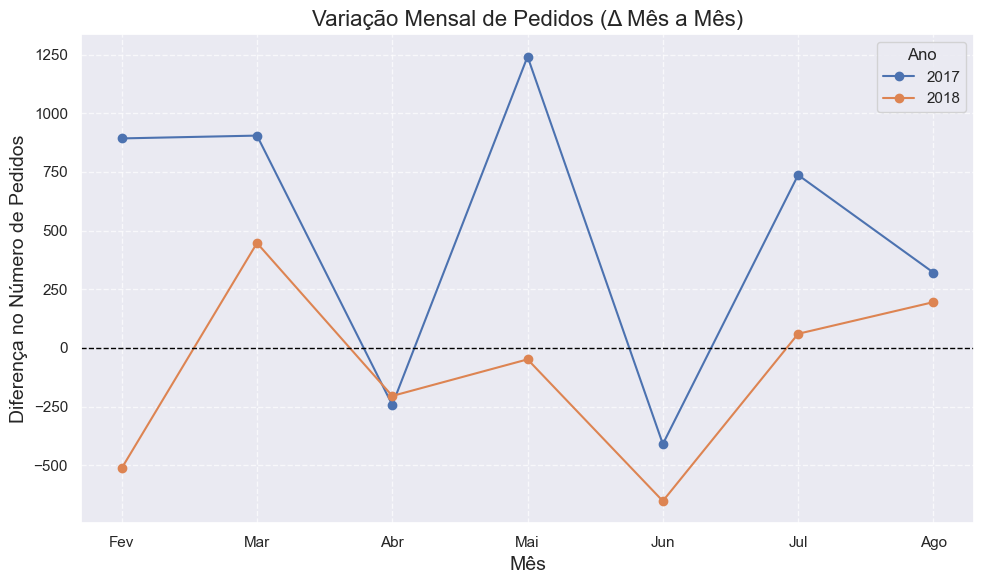

In [128]:
# Calcular a diferença mês a mês DENTRO de cada ano (por coluna)
diff_mensal = pivot.diff().dropna()

# Plotar a diferença mês a mês por ano
diff_mensal.plot(marker='o', figsize=(10, 6))

# Personalização
plt.title('Variação Mensal de Pedidos (Δ Mês a Mês)', fontsize=16)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Diferença no Número de Pedidos', fontsize=14)
plt.xticks(ticks=range(2, 9), labels=['Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago'])  # Começa em fevereiro
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Ano')
plt.tight_layout()
plt.show()

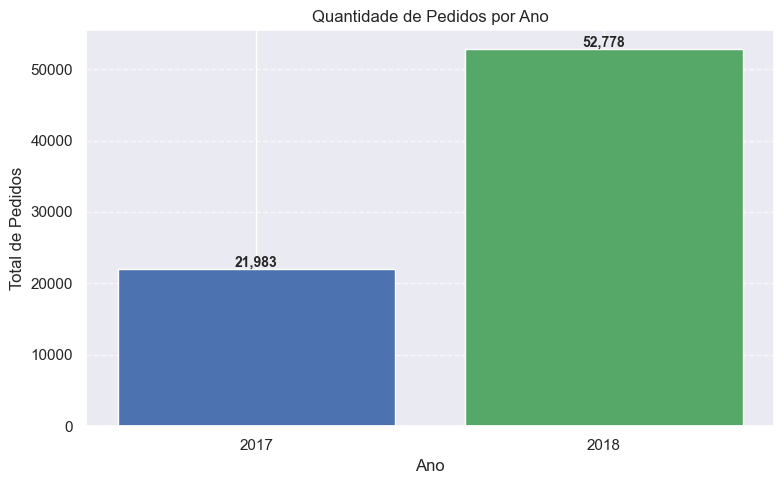

In [88]:
annual_orders = monthly_orders_valid.groupby(monthly_orders_valid.index.year).sum()
# Lista de cores (uma por barra/ano)
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3', '#ccb974']  # Pode aumentar se tiver mais anos

# Plotar
plt.figure(figsize=(8, 5))
bars = plt.bar(annual_orders.index.astype(str), annual_orders.values, color=colors[:len(annual_orders)])

# Adicionar valores no topo das barras (com separador de milhar)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:,.0f}',  # Formata como 41,898
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Configurações do gráfico
plt.title('Quantidade de Pedidos por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Pedidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [205]:

# Imprimir estatísticas mensais
print("\nEstatísticas da série temporal mensal:")
print(f"Total de meses com pedidos: {len(monthly_orders)}")
print(f"Média mensal de pedidos: {monthly_orders.mean():.2f}")
print(f"Desvio padrão mensal: {monthly_orders.std():.2f}")
print(f"Máximo de pedidos em um mês: {monthly_orders.max()}")
print(f"Mínimo de pedidos em um mês: {monthly_orders.min()}")

# Mostrar os meses com mais e menos pedidos
print("\nTop 5 meses com mais pedidos:")
top_five_months_sales = monthly_orders.nlargest(5)
top_five_months_sales.index = top_five_months_sales.index.strftime('%b-%Y')
print(top_five_months_sales)
print("\nTop 5 meses com menos pedidos:")
bottom_five_months_sales = monthly_orders.nsmallest(5)
bottom_five_months_sales.index = bottom_five_months_sales.index.strftime('%b-%Y')
print(bottom_five_months_sales.nsmallest(5))


Estatísticas da série temporal mensal:
Total de meses com pedidos: 23
Média mensal de pedidos: 4193.96
Desvio padrão mensal: 2481.29
Máximo de pedidos em um mês: 7288
Mínimo de pedidos em um mês: 1

Top 5 meses com mais pedidos:
Nov-2017    7288
Jan-2018    7069
Mar-2018    7003
Apr-2018    6798
May-2018    6749
dtype: int64

Top 5 meses com menos pedidos:
Sep-2016       1
Dec-2016       1
Oct-2016     270
Jan-2017     748
Feb-2017    1641
dtype: int64
